<a href="https://colab.research.google.com/github/geekarp/ENU-CNN-AI/blob/master/Murad_CNN_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Statistics:
Training set size: 1600
Test set size: 400

Class Distribution in Training Set:
sentiment
1    800
0    800
Name: count, dtype: int64

Text Length Statistics (Training Set):
Average length: 3913.26
Maximum length: 14957
Minimum length: 91


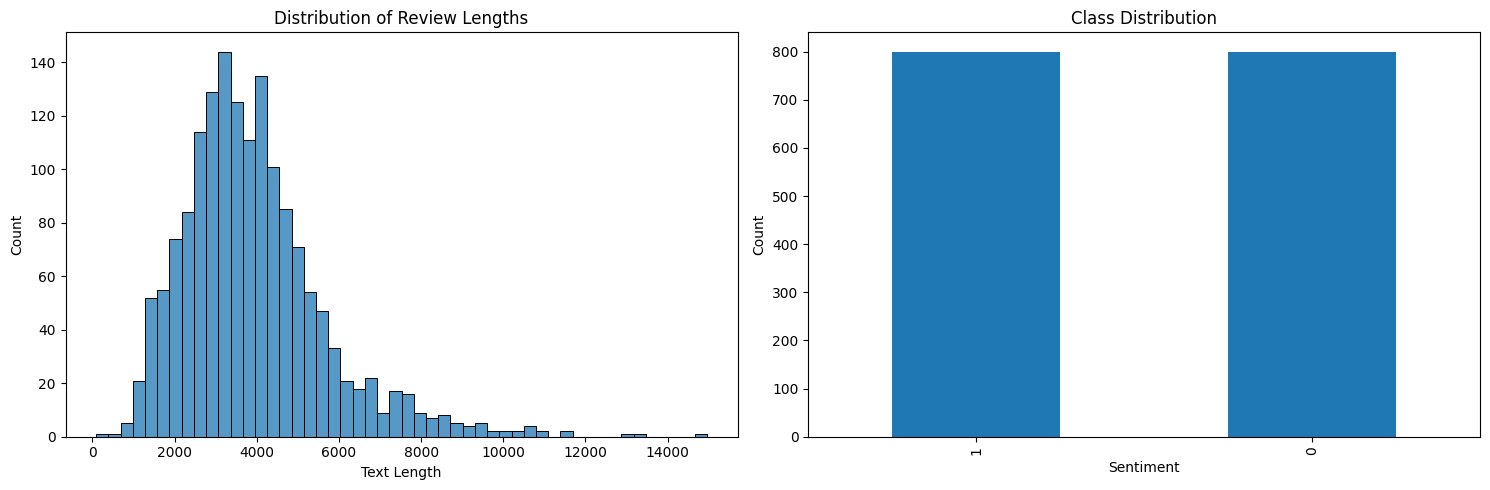

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 0.5267 - loss: 0.8444 - val_accuracy: 0.3125 - val_loss: 0.8221
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5793 - loss: 0.7633 - val_accuracy: 0.3156 - val_loss: 0.7777
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.6788 - loss: 0.6915 - val_accuracy: 0.5312 - val_loss: 0.7346
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8419 - loss: 0.5420 - val_accuracy: 0.6281 - val_loss: 0.7056
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9859 - loss: 0.2780 - val_accuracy: 0.6906 - val_loss: 0.6587
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 1.0000 - loss: 0.1389 - val_accuracy: 0.7344 - val_loss: 0.6234
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.1086 - val_accuracy: 0.7531 - val_loss: 0.6111
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 1.0000 - loss: 0.0941 - val_accuracy: 0.7312 - va

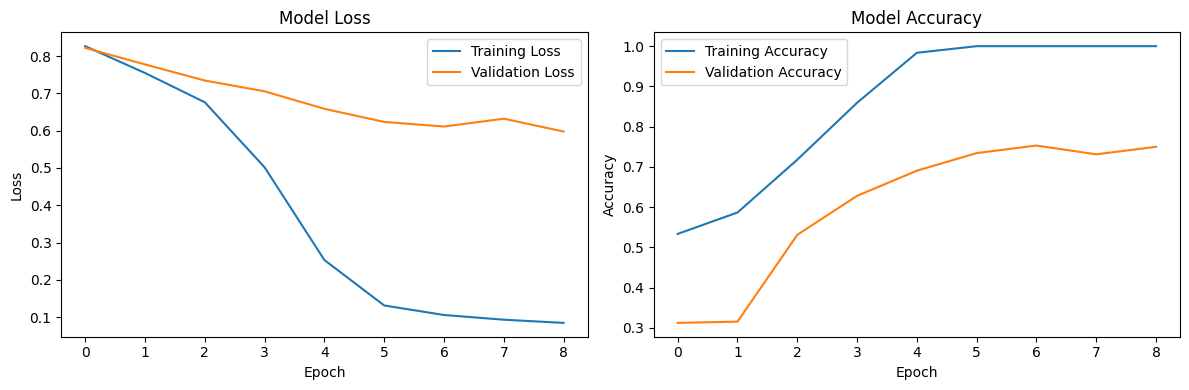

In [ ]:
# Part 1: Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential

# Part 2: Data Loading and Initial Analysis
# Read both training and test CSV files
train_df = pd.read_csv('train.csv', header=None)
test_df = pd.read_csv('test.csv', header=None)

# Rename columns for clarity
train_df.columns = ['review', 'sentiment']
test_df.columns = ['review', 'sentiment']

# Data Statistics
print("Dataset Statistics:")
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print("\nClass Distribution in Training Set:")
print(train_df['sentiment'].value_counts())

# Calculate text length statistics
train_df['text_length'] = train_df['review'].str.len()
print("\nText Length Statistics (Training Set):")
print(f"Average length: {train_df['text_length'].mean():.2f}")
print(f"Maximum length: {train_df['text_length'].max()}")
print(f"Minimum length: {train_df['text_length'].min()}")

# Part 3: Data Visualization
plt.figure(figsize=(15, 5))

# Text length distribution
plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='text_length', bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')

# Class distribution
plt.subplot(1, 2, 2)
train_df['sentiment'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Part 4: Text Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = ''.join([c if c.isalnum() or c.isspace() else ' ' for c in text])
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply preprocessing
train_df['processed_text'] = train_df['review'].apply(preprocess_text)
test_df['processed_text'] = test_df['review'].apply(preprocess_text)

# Part 5: Text Tokenization and Sequence Padding
MAX_WORDS = 10000
MAX_LENGTH = 500

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_df['processed_text'])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['processed_text']), maxlen=MAX_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['processed_text']), maxlen=MAX_LENGTH)

y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

# Part 6: Model Building with Anti-Overfitting Measures
# Modified model with balanced architecture
model = Sequential([
    Embedding(MAX_WORDS, 128, input_length=500),
    Conv1D(96, 5, activation='relu', kernel_regularizer=l2(0.001)),  # Reduced regularization
    GlobalMaxPooling1D(),
    Dense(48, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),  # Reduced dropout
    Dense(1, activation='sigmoid')
])

# Modified compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Increased learning rate
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Add class weights to handle imbalance if present
class_weights = {0: 1.0, 1: 1.0}

# Modified training
trained_model = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            restore_best_weights=True
        )
    ],
    verbose=1
)

# Part 7: Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Part 8: Visualization of Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(trained_model.history['loss'], label='Training Loss')
plt.plot(trained_model.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trained_model.history['accuracy'], label='Training Accuracy')
plt.plot(trained_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Part 9: Save Predictions
predictions_df = pd.DataFrame({
    'Review': test_df['review'],
    'Actual Sentiment': y_test,
    'Predicted Sentiment': y_pred_classes.flatten(),
    'Prediction Probability': y_pred.flatten()
})
predictions_df.to_csv('predictions.csv', index=False)